In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sage import MarginalImputer, PermutationEstimator

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from oob_methods import compute_oob_fis
from data_generator import generate_gaussian_causal_network
from utils import (
    compute_markov_blanket_detection_rates,
    prepare_boxplot_data,
    create_feature_importance_boxplots,
    create_comparative_boxplot,
    print_summary_statistics,
    test_zero_importance,
    extract_random_feature_importance,
    analyze_random_feature_importance,
    plot_random_feature_distributions,
)

In [2]:
# We will first consider the following DAG (arrows are directed downwards):
#           x_0
#            |
#       x_1 x_2
#    x_3  \  | \
#      \   \ |  \
#       x_4 x_5  x_6
#         \ /
#         x_7    x_8
# x_5 will be the target. Its Markov Blanket is (x_1, x_2, x_4, x_7) so we want these
# features to receive the highest importance.
# The only non zero weights will be w_2,0 ; w_4,3 ; w_5,1 ; w_5,2 ; w_6,2 ; w_7,4 ; w_7,5
# We choose arbitrary values for the weight, bias and variance terms and therefore define:

#             x0  x1 x2 x3 x4 x5  x6 x7 x8
b = np.array([1, -1, 0, 2, 1, 2, -2, 3, 5])

#              x0   x1   x2   x3   x4   x5   x6   x7   x8
v = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

w = np.array(
    [
        # x0   x1   x2   x3   x4   x5   x6   x7   x8
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x0
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x1
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x2
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x3
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x4
        [0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x5
        [0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x6
        [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0],  # x7
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x8
    ]
)

n_feature = len(b) - 1
idx_target = 5
idx_features = [i for i in range(n_feature + 1) if i != idx_target]
rng = np.random.RandomState(42)

# Evaluate feature selection capabilities

In [3]:
n_simulations = 100
train_size, test_size = (500, 500)
n_estimators = 50

mdi_res = dict()
ufi_res = dict()
mdi_oob_res = dict()
naive_oob_res = dict()
j_score_res = dict()
sage_res = dict()
permut_res = dict()

for sim in range(n_simulations):
    Xy, mu, Sigma = generate_gaussian_causal_network(
        n_sample=train_size + test_size,
        b=b,
        v=v,
        w=w,
        random_state=rng,
    )
    X, y = Xy[:, idx_features], Xy[:, idx_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=rng
    )

    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        oob_score=True,
        n_jobs=-1,
        random_state=rng,
    ).fit(X_train, y_train)

    mdi_res[sim] = regressor._unnormalized_feature_importances
    feature_importance_res = compute_oob_fis(
        regressor,
        X_train,
        y_train,
        mean_squared_error,
        ["UFI", "MDI-oob", "j-score", "naive-oob"],
    )
    ufi_res[sim] = feature_importance_res["UFI"]
    mdi_oob_res[sim] = feature_importance_res["MDI-oob"]
    j_score_res[sim] = feature_importance_res["j-score"]
    naive_oob_res[sim] = feature_importance_res["naive-oob"]

    imputer = MarginalImputer(regressor, X_test)
    estimator = PermutationEstimator(imputer, "mse", random_state=rng)
    sage_res[sim] = estimator(X_test, y_test, thresh=0.1, bar=False).values

    permut_res[sim] = permutation_importance(
        regressor, X_test, y_test, n_repeats=5, random_state=rng
    ).importances_mean


In [8]:
# Analyze all methods
markov_blanket_features = [1, 2, 4, 7]  # Original feature indices
# Note: These correspond to importance indices [1, 2, 4, 6] since feature 5 is target
methods = {
    'MDI': mdi_res,
    'naive-oob': naive_oob_res,
    'UFI': ufi_res, 
    'MDI-OOB': mdi_oob_res,
    'J-Score': j_score_res,
    'Permutation': permut_res,
    'SAGE': sage_res,
}

print("Markov Blanket Detection Results")
print("=" * 50)
print(f"Target Markov Blanket: Features {markov_blanket_features} (original indices)")
print("In importance arrays: indices [1, 2, 4, 6] (feature 5 is target, skipped)")
print(f"Total Simulations: {n_simulations}")
print()

results_summary = {}

for method_name, results_dict in methods.items():
    success_count, total_sims, success_rate = compute_markov_blanket_detection_rates(
        results_dict, method_name, markov_blanket_features
    )
    
    results_summary[method_name] = {
        'success_count': success_count,
        'total_simulations': total_sims,
        'success_rate': success_rate
    }
    
    print(f"{method_name:12} | Found MB: {success_count:2d}/{total_sims:2d} times ({success_rate:6.1%})")

# Summary statistics
print(f"\n" + "=" * 50)
print("SUMMARY:")
best_method = max(results_summary.keys(), key=lambda x: results_summary[x]['success_rate'])
worst_method = min(results_summary.keys(), key=lambda x: results_summary[x]['success_rate'])

print(f"Best performing method:  {best_method} ({results_summary[best_method]['success_rate']:.1%})")
print(f"Worst performing method: {worst_method} ({results_summary[worst_method]['success_rate']:.1%})")

Markov Blanket Detection Results
Target Markov Blanket: Features [1, 2, 4, 7] (original indices)
In importance arrays: indices [1, 2, 4, 6] (feature 5 is target, skipped)
Total Simulations: 100

MDI          | Found MB: 57/100 times ( 57.0%)
naive-oob    | Found MB: 33/100 times ( 33.0%)
UFI          | Found MB: 64/100 times ( 64.0%)
MDI-OOB      | Found MB: 68/100 times ( 68.0%)
J-Score      | Found MB: 38/100 times ( 38.0%)
Permutation  | Found MB: 87/100 times ( 87.0%)
SAGE         | Found MB: 28/100 times ( 28.0%)

SUMMARY:
Best performing method:  Permutation (87.0%)
Worst performing method: SAGE (28.0%)


SUMMARY STATISTICS
Mean importance scores by method and feature:
--------------------------------------------------

MDI:
  Feature | Mean     | Std      | Median   | Min      | Max      | MB?
  --------|----------|----------|----------|----------|----------|----
        0 |   0.0495 |   0.0073 |   0.0487 |   0.0360 |   0.0801 | No 
        1 |   0.1529 |   0.0258 |   0.1483 |   0.1041 |   0.2256 | Yes
        2 |   0.2852 |   0.0500 |   0.2876 |   0.1821 |   0.4135 | Yes
        3 |   0.0473 |   0.0066 |   0.0468 |   0.0321 |   0.0642 | No 
        4 |   0.0568 |   0.0085 |   0.0560 |   0.0397 |   0.0780 | Yes
        6 |   0.0491 |   0.0071 |   0.0477 |   0.0343 |   0.0725 | No 
        7 |   0.1779 |   0.0391 |   0.1709 |   0.1074 |   0.2924 | Yes
        8 |   0.0475 |   0.0065 |   0.0465 |   0.0345 |   0.0669 | No 

naive-oob:
  Feature | Mean     | Std      | Median   | Min      | Max      | MB?
  --------|----------|----------|----------|----------|----------|----
        0 |   

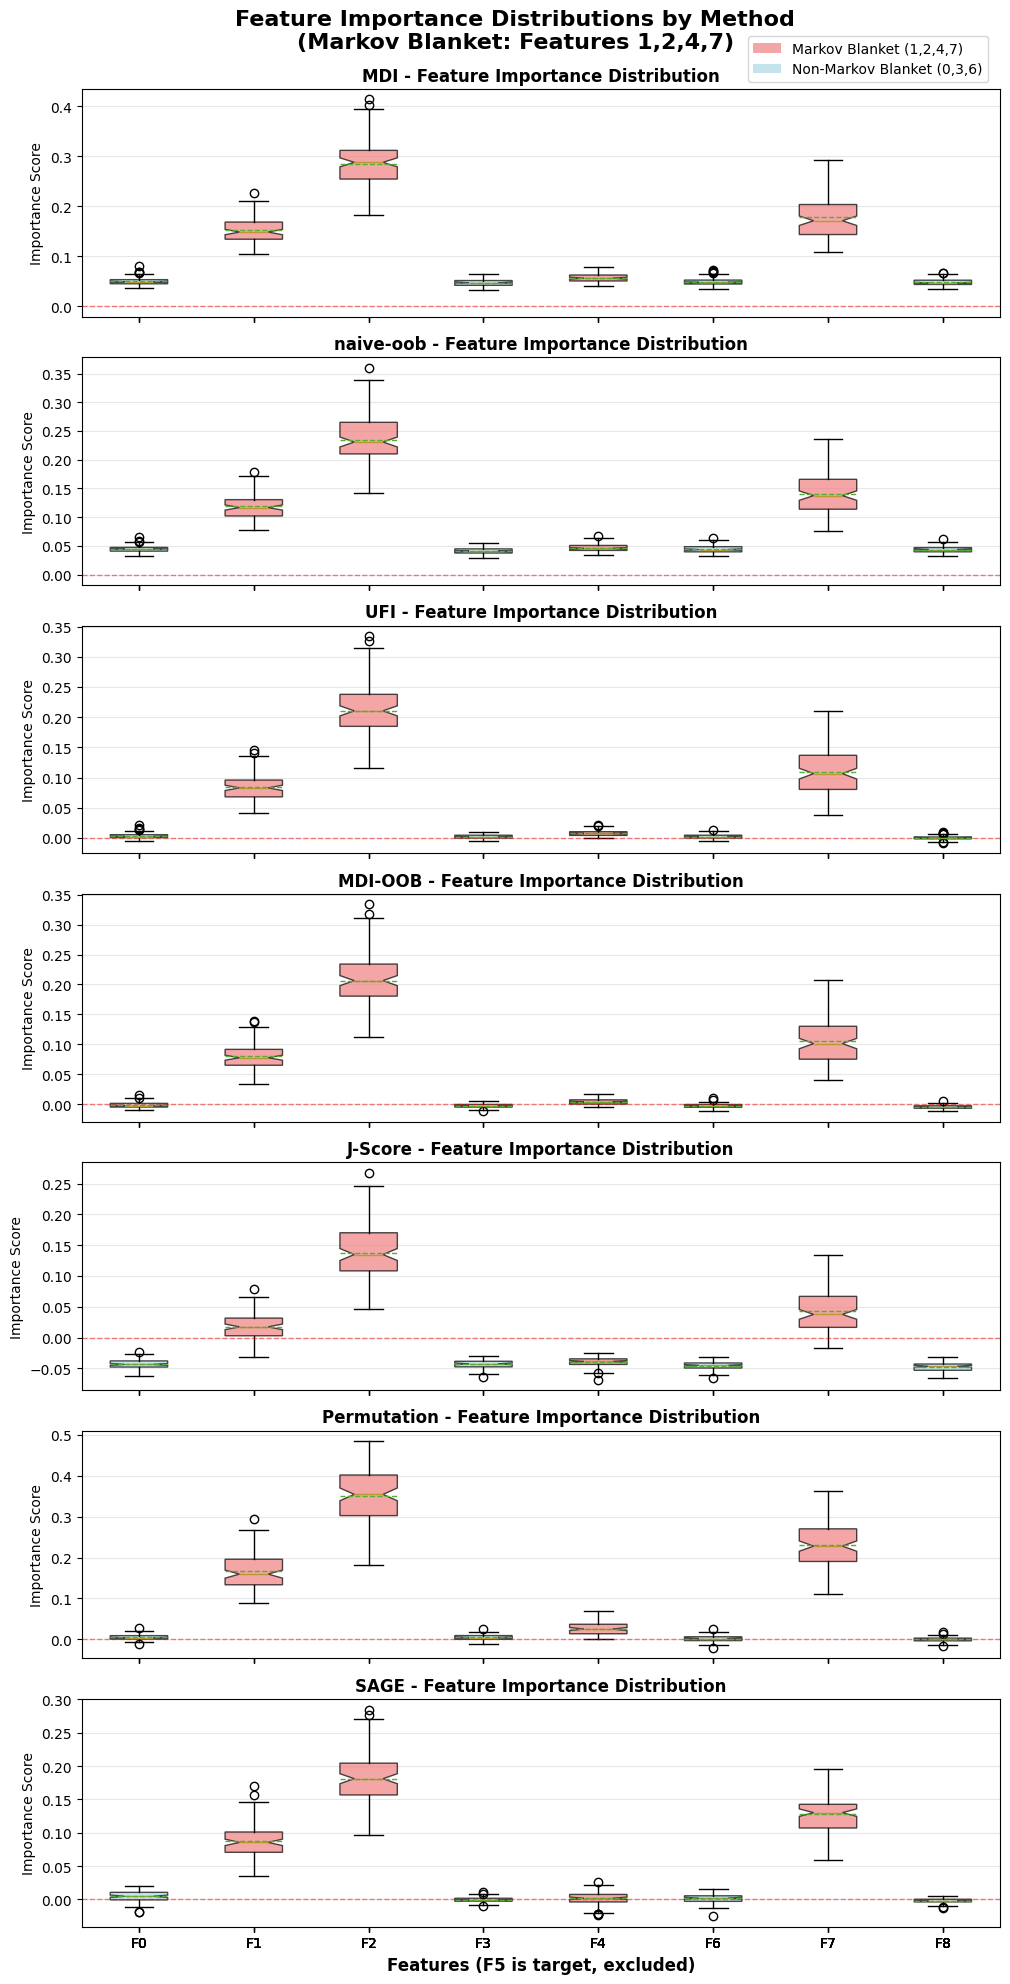

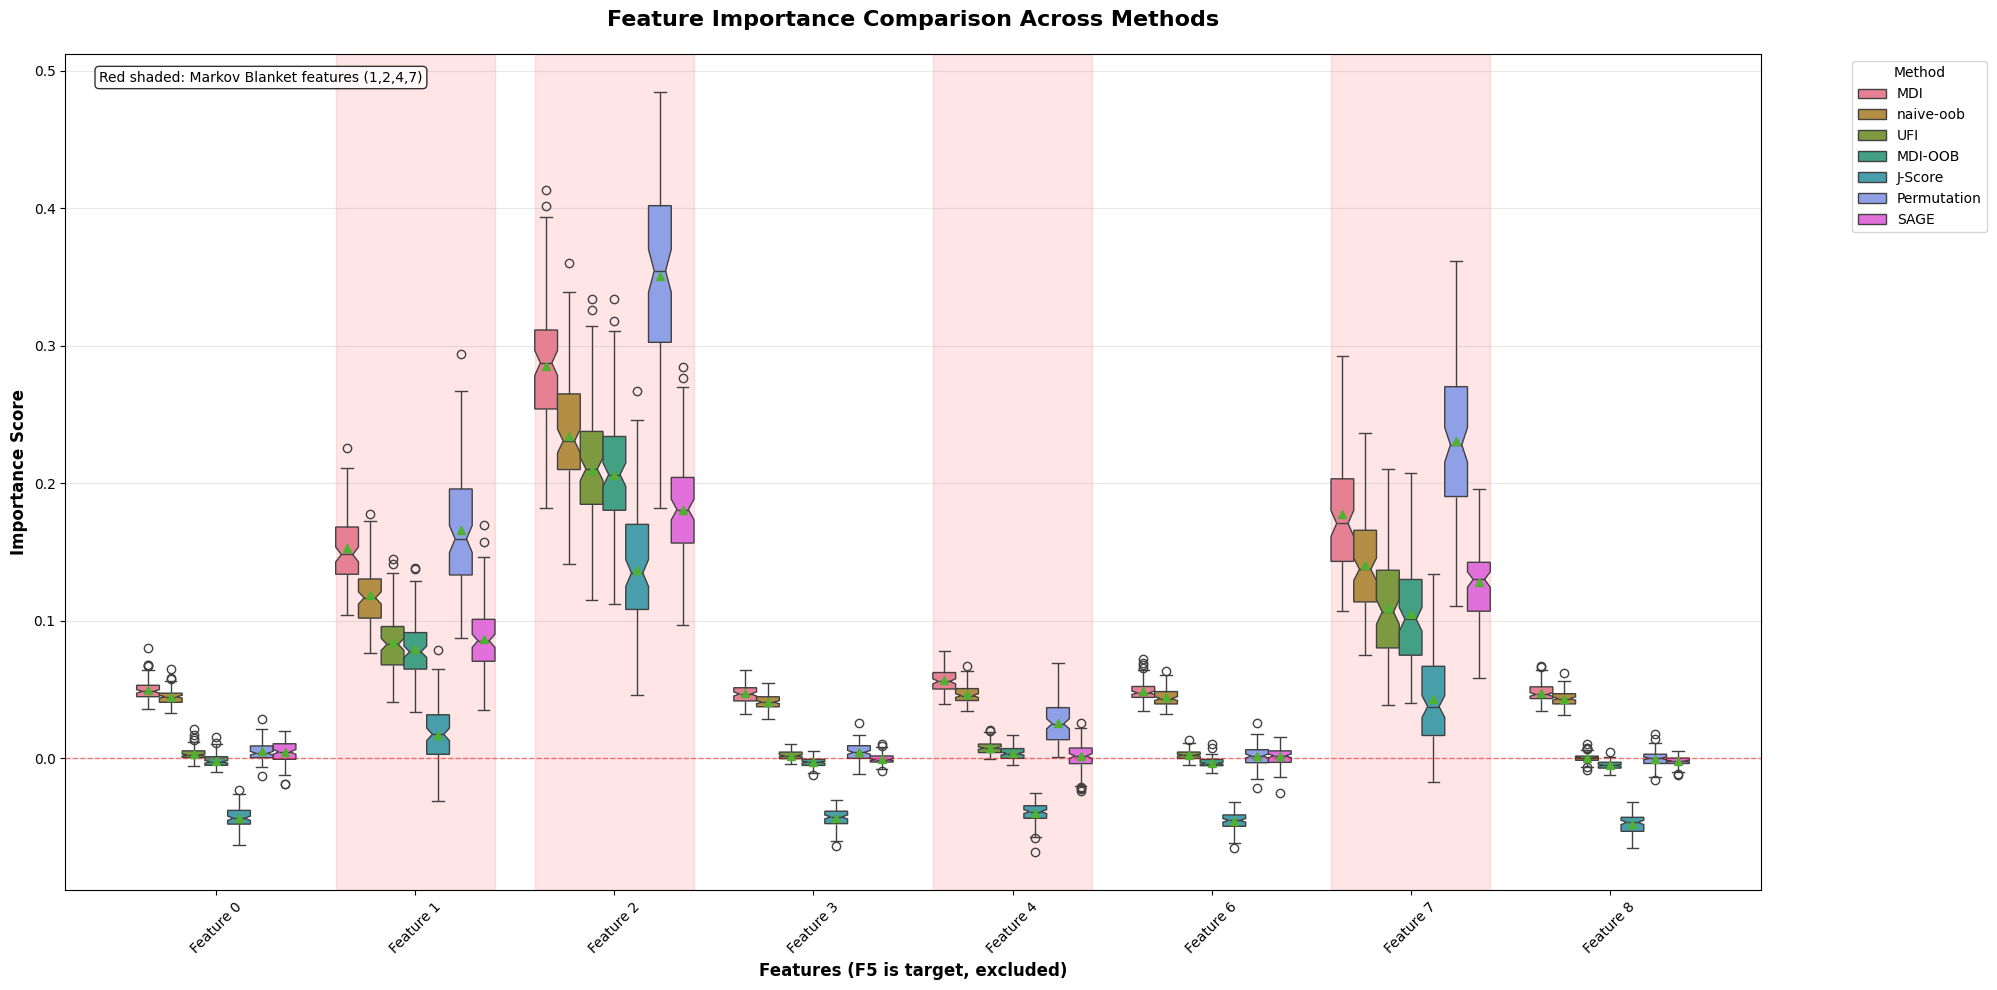


RANKING ANALYSIS
------------------------------

MDI - Average Feature Ranking (1=highest importance):
  Feature 0: Rank 5  
  Feature 1: Rank 3 ★
  Feature 2: Rank 1 ★
  Feature 3: Rank 8  
  Feature 4: Rank 4 ★
  Feature 6: Rank 6  
  Feature 7: Rank 2 ★
  Feature 8: Rank 7  
  Top 4 features: [1, 2, 4, 7] | Contains full MB: YES

naive-oob - Average Feature Ranking (1=highest importance):
  Feature 0: Rank 5  
  Feature 1: Rank 3 ★
  Feature 2: Rank 1 ★
  Feature 3: Rank 8  
  Feature 4: Rank 4 ★
  Feature 6: Rank 6  
  Feature 7: Rank 2 ★
  Feature 8: Rank 7  
  Top 4 features: [1, 2, 4, 7] | Contains full MB: YES

UFI - Average Feature Ranking (1=highest importance):
  Feature 0: Rank 5  
  Feature 1: Rank 3 ★
  Feature 2: Rank 1 ★
  Feature 3: Rank 7  
  Feature 4: Rank 4 ★
  Feature 6: Rank 6  
  Feature 7: Rank 2 ★
  Feature 8: Rank 8  
  Top 4 features: [1, 2, 4, 7] | Contains full MB: YES

MDI-OOB - Average Feature Ranking (1=highest importance):
  Feature 0: Rank 5  
  Feat

In [9]:
# Print summary statistics
print_summary_statistics(methods, n_simulations)

# Create individual method boxplots
fig1 = create_feature_importance_boxplots(methods, n_simulations)
fig1.suptitle('Feature Importance Distributions by Method\n(Markov Blanket: Features 1,2,4,7)', 
              fontsize=16, fontweight='bold', y=0.99)
plt.show()

# Create comparative boxplot
fig2 = create_comparative_boxplot(methods, n_simulations)
plt.show()

# Additional analysis: Rank-based comparison
print(f"\n" + "=" * 80)
print("RANKING ANALYSIS")
print("-" * 30)

df = prepare_boxplot_data(methods, n_simulations)

for method in methods.keys():
    method_data = df[df['Method'] == method]
    
    # Calculate average rank for each feature
    feature_means = method_data.groupby('Original_Feature_Index')['Importance'].mean()
    feature_ranks = feature_means.rank(ascending=False).astype(int)
    
    print(f"\n{method} - Average Feature Ranking (1=highest importance):")
    for feature in [0, 1, 2, 3, 4, 6, 7, 8]:
        if feature in feature_ranks:
            is_mb = "★" if feature in [1, 2, 4, 7] else " "
            print(f"  Feature {feature}: Rank {feature_ranks[feature]} {is_mb}")
    
    # Check if top 4 features include all Markov blanket features
    top_4_features = feature_means.nlargest(4).index.tolist()
    mb_in_top4 = set([1, 2, 4, 7]).issubset(set(top_4_features))
    print(f"  Top 4 features: {sorted(top_4_features)} | Contains full MB: {'YES' if mb_in_top4 else 'NO'}")

In [10]:
# Run the analysis
random_feature_idx = 8  # Original index of random feature

# Perform statistical analysis
test_results = analyze_random_feature_importance(methods, random_feature_idx, alpha=0.05)

# Additional analysis with different significance levels
print(f"\n" + "=" * 70)
print("SENSITIVITY ANALYSIS - Different Significance Levels:")
print("-" * 50)

for alpha_test in [0.01, 0.05, 0.10]:
    print(f"\nα = {alpha_test}:")
    zero_count = 0
    for method_name, results_dict in methods.items():
        scores = extract_random_feature_importance(results_dict, random_feature_idx)
        test_result = test_zero_importance(scores, random_feature_idx, alpha_test)
        is_zero = "YES" if test_result['is_zero_ttest'] else "NO"
        print(f"  {method_name:12}: {is_zero}")
        if test_result['is_zero_ttest']:
            zero_count += 1
    print(f"  Total methods with zero importance: {zero_count}/{len(methods)}")

# Effect size analysis (Cohen's d against zero)
print(f"\n" + "=" * 70)
print("EFFECT SIZE ANALYSIS (Cohen's d):")
print("-" * 30)

for method_name, results_dict in methods.items():
    scores = extract_random_feature_importance(results_dict, random_feature_idx)
    if len(scores) > 0:
        cohens_d = np.mean(scores) / np.std(scores, ddof=1) if np.std(scores, ddof=1) > 0 else 0
        effect_size = "negligible" if abs(cohens_d) < 0.2 else "small" if abs(cohens_d) < 0.5 else "medium" if abs(cohens_d) < 0.8 else "large"
        print(f"{method_name:12}: d = {cohens_d:7.3f} ({effect_size})")


Statistical Test for Random Feature (Index 8)
H0: Feature 8 has zero importance (mean = 0)
H1: Feature 8 has non-zero importance (mean ≠ 0)
Significance level: α = 0.05

MDI          | n=100 | mean=  0.0475 | std=  0.0065 | t= 72.924 | p= 0.0000 | Zero: NO 
naive-oob    | n=100 | mean=  0.0433 | std=  0.0056 | t= 76.977 | p= 0.0000 | Zero: NO 
UFI          | n=100 | mean=  0.0003 | std=  0.0032 | t=  0.823 | p= 0.4123 | Zero: YES
MDI-OOB      | n=100 | mean= -0.0050 | std=  0.0030 | t=-16.850 | p= 0.0000 | Zero: NO 
J-Score      | n=100 | mean= -0.0475 | std=  0.0070 | t=-67.911 | p= 0.0000 | Zero: NO 
Permutation  | n=100 | mean= -0.0003 | std=  0.0057 | t= -0.476 | p= 0.6348 | Zero: YES
SAGE         | n=100 | mean= -0.0020 | std=  0.0036 | t= -5.612 | p= 0.0000 | Zero: NO 

Methods that assign ZERO importance (t-test, α=0.05):
  UFI, Permutation

Methods that assign ZERO importance (Wilcoxon test, α=0.05):
  UFI, Permutation

SENSITIVITY ANALYSIS - Different Significance Levels:
----

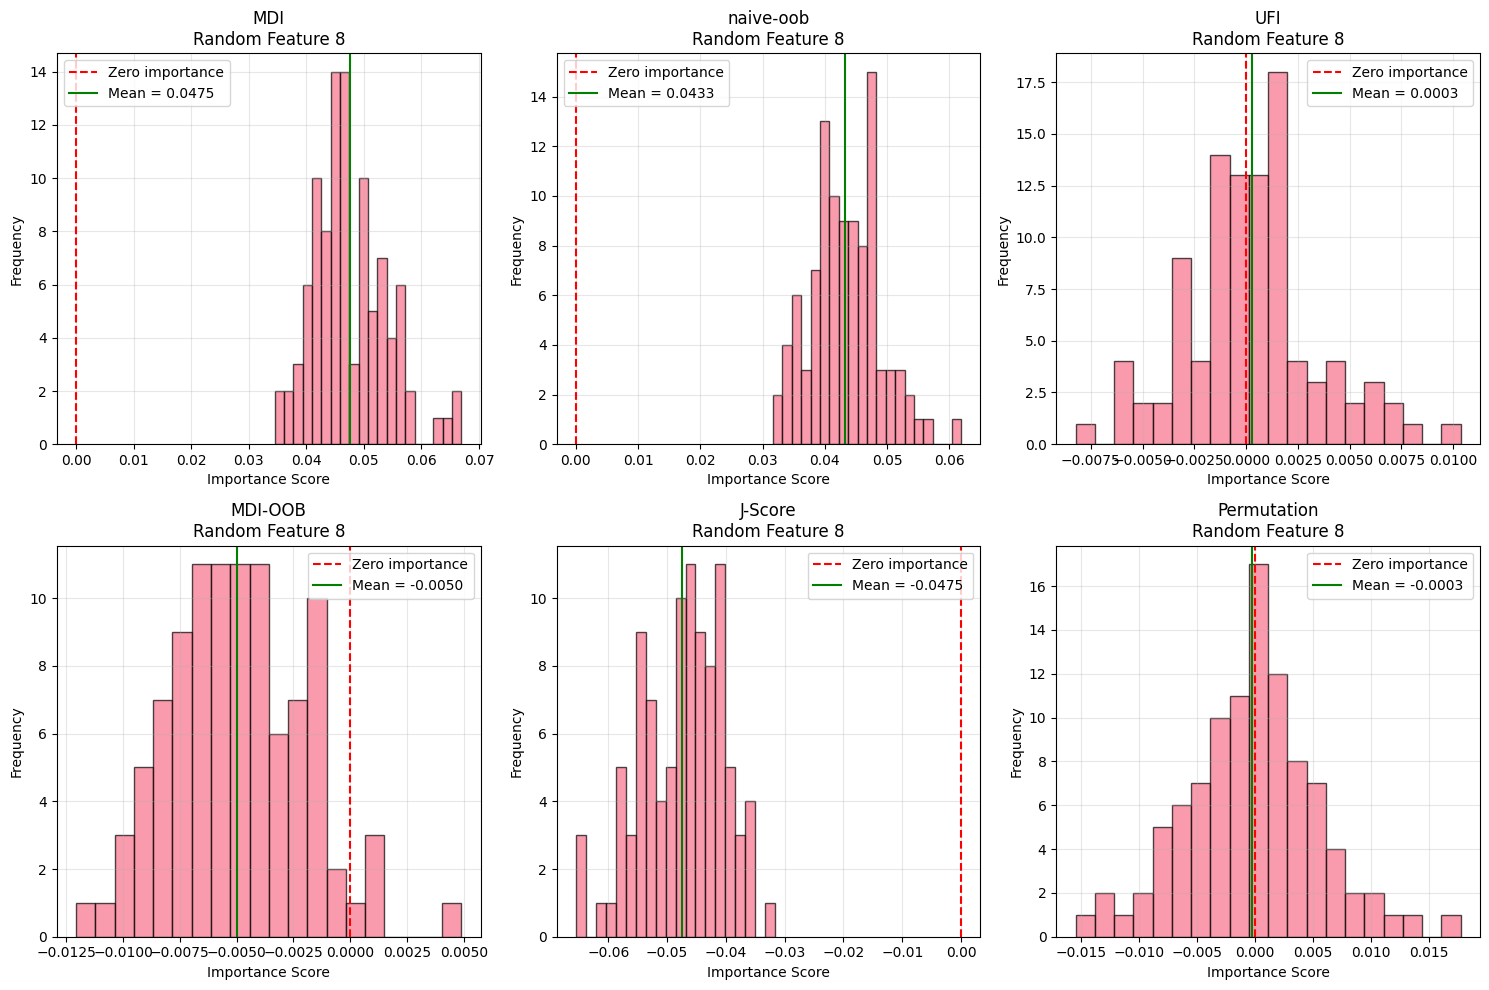

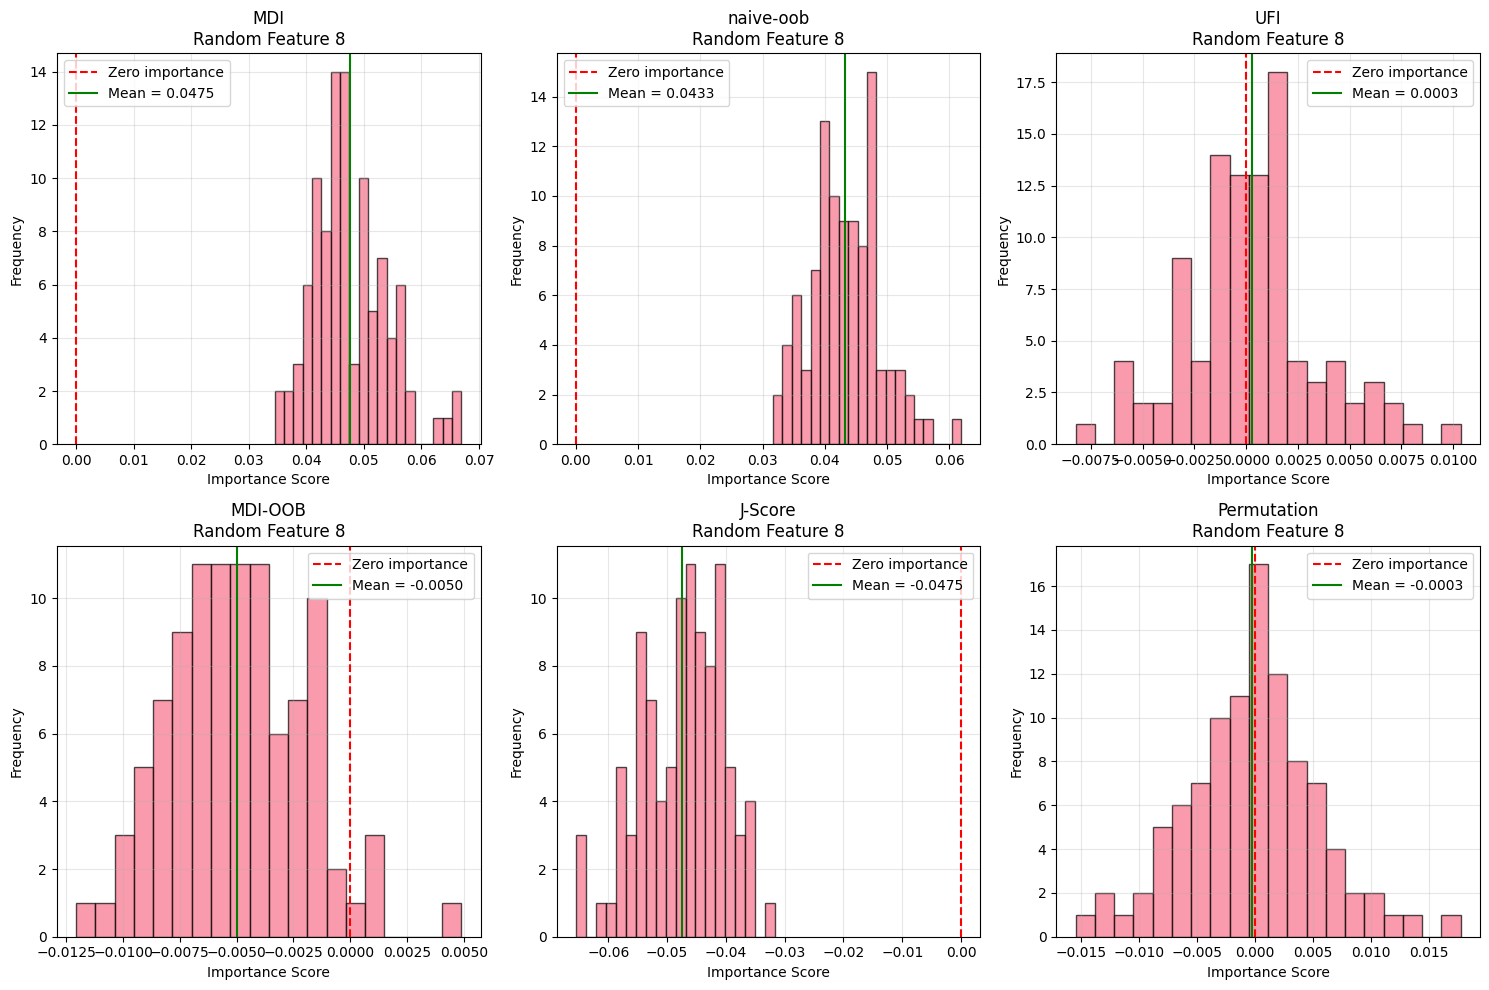

In [11]:
plot_random_feature_distributions(methods, random_feature_idx)
